# 1.0 An end-to-end classification problem (Training)



## 1.1 Dataset description

The notebooks focus on a borrower's **credit modeling problem**. The database was downloaded through a dataquest project and is available at link below. The data is from **Lending Club** and contains data from loans made in the period **2007 to 2011**. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. The **target variable**, or what we are wanting to predict, is whether or not, given a person's history, they will repay the loan.

You can download the data from the [Kaggle](https://www.kaggle.com/datasets/samaxtech/lending-club-20072011-data).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>

## 1.2 Install, load libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 45.4 MB/s 
     |████████████████████████████████| 153 kB 53.0 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=367cade840c36089f57876335243d2d11837a8be8c28b10f43e54c973baf1250
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import os
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 1.3 Holdout Configuration

In [4]:
# global variables

# ratio used to split train and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "loan_status"

# name of the input artifact
artifact_input_name = "neural_network/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [5]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="neural_network",job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


24-07-2022 16:38:26 Downloading and reading train artifact
24-07-2022 16:38:27 Spliting data into train/val


In [6]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

24-07-2022 16:38:27 x train: (18460, 17)
24-07-2022 16:38:27 y train: (18460,)
24-07-2022 16:38:27 x val: (7912, 17)
24-07-2022 16:38:27 y val: (7912,)


## 1.4 Data preparation

### 1.4.1 Outlier Removal

In [7]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("float64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

24-07-2022 16:38:27 Outlier Removal


In [8]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

24-07-2022 16:38:28 x_train shape [original]: (18460, 17)
24-07-2022 16:38:28 x_train shape [outlier removal]: (18431, 17)


In [9]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 1.4.2 Encoding Target Variable

In [10]:
y_train.head(10)

5525     Fully Paid
19011    Fully Paid
20964    Fully Paid
20533    Fully Paid
8244     Fully Paid
8138     Fully Paid
12371    Fully Paid
3891     Fully Paid
21678    Fully Paid
5197     Fully Paid
Name: loan_status, dtype: object

In [11]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

24-07-2022 16:38:28 Encoding Target Variable
24-07-2022 16:38:28 Classes [0, 1]: ['Charged Off' 'Fully Paid']


In [12]:
y_train

array([1, 1, 1, ..., 1, 1, 0])

In [13]:
y_val

array([1, 0, 1, ..., 0, 1, 1])

### 1.4.3 Using a full-pipeline

```
A reproducible pipeline is all you need
```

#### 1.4.3.1 Feature Extractor

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [15]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,< 1 year,RENT,Source Verified,wedding
19011,36 months,10+ years,MORTGAGE,Verified,other
20964,36 months,5 years,RENT,Source Verified,debt_consolidation
20533,36 months,3 years,MORTGAGE,Not Verified,credit_card
8244,36 months,3 years,RENT,Verified,other


In [16]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
5525,14400.0,17.93,243.42,120000.0,21.60,0.0,0.0,15.0,0.0,25420.0,73.3,25.0
19011,16000.0,11.71,529.22,88000.0,19.95,0.0,0.0,8.0,0.0,12075.0,41.2,56.0
20964,10000.0,7.88,312.82,64800.0,13.98,0.0,2.0,7.0,0.0,364.0,1.6,26.0
20533,5700.0,6.91,175.77,45000.0,7.57,0.0,1.0,4.0,0.0,5057.0,56.2,23.0
8244,2000.0,10.99,65.47,50400.0,24.71,0.0,0.0,22.0,0.0,27541.0,88.8,30.0


#### 1.4.3.2 Handling Categorical Features

In [17]:
# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:

            #adjust emp_lenght feature
            mapping_dict = {
                "emp_length": {
                    "10+ years": 10,
                    "9 years": 9,
                    "8 years": 8,
                    "7 years": 7,
                    "6 years": 6,
                    "5 years": 5,
                    "4 years": 4,
                    "3 years": 3,
                    "2 years": 2,
                    "1 year": 1,
                    "< 1 year": 0,
                    "n/a": 0
                }
            }
            df = df.replace(mapping_dict)

        # update column names
        self.colnames = df.columns
            
        return df


In [18]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,< 1 year,RENT,Source Verified,wedding
19011,36 months,10+ years,MORTGAGE,Verified,other
20964,36 months,5 years,RENT,Source Verified,debt_consolidation
20533,36 months,3 years,MORTGAGE,Not Verified,credit_card
8244,36 months,3 years,RENT,Verified,other


In [19]:
# for validation purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,0,RENT,Source Verified,wedding
19011,36 months,10,MORTGAGE,Verified,other
20964,36 months,5,RENT,Source Verified,debt_consolidation
20533,36 months,3,MORTGAGE,Not Verified,credit_card
8244,36 months,3,RENT,Verified,other


#### 1.4.3.3 Handling Numerical Features

In [20]:
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [21]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
5525,14400.0,17.93,243.42,120000.0,21.60,0.0,0.0,15.0,0.0,25420.0,73.3,25.0
19011,16000.0,11.71,529.22,88000.0,19.95,0.0,0.0,8.0,0.0,12075.0,41.2,56.0
20964,10000.0,7.88,312.82,64800.0,13.98,0.0,2.0,7.0,0.0,364.0,1.6,26.0
20533,5700.0,6.91,175.77,45000.0,7.57,0.0,1.0,4.0,0.0,5057.0,56.2,23.0
8244,2000.0,10.99,65.47,50400.0,24.71,0.0,0.0,22.0,0.0,27541.0,88.8,30.0


In [22]:
# for validation purposes
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[ 0.43105921,  1.61158526, -0.39726645, ...,  0.76559949,
         0.86201652,  0.26250589],
       [ 0.64767724, -0.07295841,  0.96521003, ..., -0.0789009 ,
        -0.27370592,  2.99922025],
       [-0.16464039, -1.11022565, -0.06642017, ..., -0.81999824,
        -1.67478408,  0.350787  ],
       ...,
       [ 1.18922233, -0.23545458,  0.52056978, ..., -0.58300656,
        -1.31390032, -1.59139738],
       [-0.69264684, -0.26795382, -0.92557171, ..., -0.08605178,
         1.44933716, -0.62030519],
       [-0.16464039,  0.33599029,  0.05366654, ...,  0.09493519,
         0.97169688, -1.23827295]])

In [23]:
# return columns name
nt.get_feature_names_out()

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

#### 1.4.3.4 Data Preparation Pipeline

In [24]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       ('cat_encoder', OneHotEncoder(handle_unknown="ignore",sparse=False, drop="first"))
                                       ]
                                )

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pipelines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                              )

In [25]:
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df_new_train = pd.DataFrame(new_data,columns = cat_names + num_names)
df_new_train.head()

,term_60 months,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,...,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.176550,0.127517,0.721202,0.0,0.000,0.325,0.0,0.170003,0.733734,0.261364
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.398724,0.091723,0.666110,0.0,0.000,0.150,0.0,0.080755,0.412412,0.613636
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.230500,0.065772,0.466778,0.0,0.250,0.125,0.0,0.002434,0.016016,0.272727
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.123960,0.043624,0.252755,0.0,0.125,0.050,0.0,0.033820,0.562563,0.238636
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038216,0.049664,0.825042,0.0,0.000,0.500,0.0,0.184187,0.888889,0.318182


In [26]:
df_new_train.shape

(18431, 42)

In [27]:
y_train.shape

(18431,)

df_new_train has one more column after transformation: `home_ownership_NONE`. So we add it to df_new_val

In [28]:
new_data_val = full_pipeline_preprocessing.transform(x_val)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
#cat_names.append('home_ownership_NONE')
df_new_val = pd.DataFrame(new_data_val,columns = cat_names + num_names)
df_new_val.head()

,term_60 months,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,...,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.588543,0.127517,0.473122,0.000000,0.000,0.200,0.0,0.187217,0.477477,0.181818
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.588574,0.085011,0.408347,0.000000,0.000,0.350,0.0,0.142817,0.387387,0.454545
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.127979,0.038591,0.404674,0.090909,0.000,0.075,0.0,0.030530,0.681682,0.102273
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.044559,0.024049,0.776628,0.090909,0.000,0.200,0.0,0.101821,0.550551,0.215909
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.336347,0.032438,0.547245,0.000000,0.375,0.175,0.0,0.141272,0.873874,0.079545


In [29]:
len(cat_names)

30

In [30]:
len(num_names)

12

In [31]:
df_new_val.shape

(7912, 42)

In [32]:
y_val.shape

(7912,)

#### 1.4.4.4 Creating the model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import SGD
from wandb.keras import WandbCallback
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import pytz

In [34]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%a, %d %b %Y %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%a, %d %b %Y %H:%M:%S")))
    print('Duration: {:.2f} seconds'.format(time.time() - self.begins))  

In [35]:
input_layer_1 = 42

model = Sequential()
model.add(Dense(100, input_dim=input_layer_1, activation='relu',
                kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.01, momentum=0.7)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

## 1.5 Holdout Training

In this example the inference artifacts are:
- full_pipeline_preprocessing (contains the preprocesing pipeline)
- model (contains the model trained)
- le (label encoder object used to encode the target variable)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


23-07-2022 19:29:03 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/math_ops.py:3836: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
23-07-2022 19:33:26 Infering
23-07-2022 19:33:27 Train: 0.863, Test: 0.855


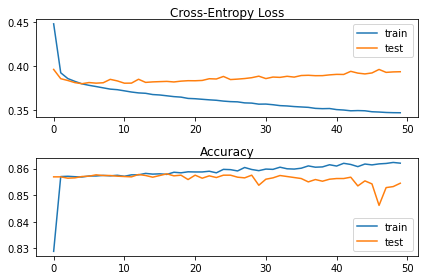

In [ ]:
# fit model
history = model.fit(df_new_train, y_train, 
                    validation_data=(df_new_val, y_val), 
                    epochs=50, verbose=0, 
                    batch_size=64,
                    callbacks=[WandbCallback(log_weights=True,
                                             log_gradients=True,
                                             training_data=(df_new_train,y_train))])

# evaluate the model
logger.info("Infering")
train_loss, train_acc = model.evaluate(df_new_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(df_new_val, y_val, verbose=0)
logger.info('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4300      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,401
Trainable params: 4,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
run.summary["Train Acc"] = train_acc
run.summary["Train Loss"] = train_loss
run.summary["Test Acc"] = test_acc
run.summary["Test Loss"] = test_loss

In [ ]:
predict = model.predict(df_new_val)

for i in range(len(predict)):
  if predict[i] > 0.5:
    predict[i] = 1
  else:
    predict[i] = 0

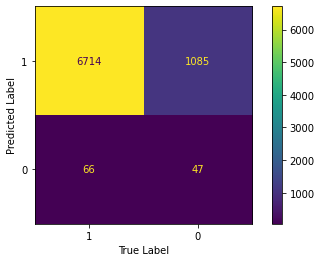

In [ ]:

fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

23-07-2022 19:42:19 Uploading figures


In [ ]:
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [ ]:
# Catch up the class proportions between train and validation
wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

In [ ]:
# close the current run before to execute the next section
run.finish()

accuracy,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▇▇▇▇███▇▇███████▇█▇█▇▇█▇▇█▇▇▆▇▆▇▇▇▅▆▁▅▆
val_loss,█▃▂▁▁▁▁▃▁▁▃▁▂▂▂▂▂▂▃▃▃▃▃▄▃▄▄▅▅▅▅▅▅▅▇▆▆█▇▇
GFLOPS,0.0
Test Acc,0.85452
Test Loss,0.39339
Train Acc,0.86333
Train Loss,0.34094
accuracy,0.86208


## 1.6 Hyperparameter Tuning

### 1.6.1 Testing with 50 neurons

In [ ]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [36]:
sweep_config = {
    # try grid or random
    'method': 'grid', #grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    "parameters": {
        "epoch": {
            "values": [50, 100, 150]
            },
        "batch_size": {
            "values": [16,32,64]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="morsinaldo", project="neural_network")

Create sweep with ID: ek70zmvb
Sweep URL: https://wandb.ai/morsinaldo/neural_network/sweeps/ek70zmvb


In [37]:
def create_model():
  input_layer_1 = 42

  model = Sequential()
  model.add(Dense(50, input_dim=input_layer_1, activation='relu',
                  kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.01, momentum=0.7)
  model.compile(loss='binary_crossentropy', 
                optimizer='adam', metrics=['accuracy'])
  return model

In [38]:
def train():
  wandb.init(project='neural_network')

  config = wandb.config

  # Create model
  model = create_model()

  # fit model
  model.fit(df_new_train, y_train, 
                    validation_data=(df_new_val, y_val), 
                    epochs=config.epoch, verbose=1, 
                    batch_size=config.batch_size,
                    callbacks=[WandbCallback(log_weights=True,
                                             log_gradients=True,
                                             training_data=(df_new_train,y_train),
                                             validation_data=(df_new_val,y_val))])

  run.finish()

In [39]:
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: j6nsgxcu with config:
wandb: 	batch_size: 16
wandb: 	epoch: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


24-07-2022 10:28:13 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/math_ops.py:3836: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/50
1152/1152 [==============================] - 6s 4ms/step - loss: 0.4177 - accuracy: 0.8470 - val_loss: 0.3881 - val_accuracy: 0.8569 - _timestamp: 1658658498.0000 - _runtime: 11.0000
Epoch 2/50
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3866 - accuracy: 0.8562 - val_loss: 0.3833 - val_accuracy: 0.8567 - _timestamp: 1658658504.0000 - _runtime: 17.0000
Epoch 3/50
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3821 - accuracy: 0.8562 - val_loss: 0.3809 - val_accuracy: 0.8571 - _timestamp: 1658658509.0000 - _runtime: 22.0000
Epoch 4/50
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3800 - accuracy: 0.8564 - val_loss: 0.3825 - val_accuracy: 0.8571 - _timestamp: 1658658514.0000 - _runtime: 27.0000
Epoch 5/50
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3785 - accuracy: 0.8570 - val_loss: 0.3850 - val_accuracy: 0.8572 - _timestamp: 1658658518.0000 - _runtime: 31.0000
Epoch 6/50
1152/1152 [========

wandb: Agent Starting Run: sobvbzto with config:
wandb: 	batch_size: 16
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.4147 - accuracy: 0.8482 - val_loss: 0.3887 - val_accuracy: 0.8571 - _timestamp: 1658658779.0000 - _runtime: 12.0000
Epoch 2/100
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3871 - accuracy: 0.8571 - val_loss: 0.3817 - val_accuracy: 0.8568 - _timestamp: 1658658783.0000 - _runtime: 16.0000
Epoch 3/100
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3828 - accuracy: 0.8570 - val_loss: 0.3812 - val_accuracy: 0.8572 - _timestamp: 1658658787.0000 - _runtime: 20.0000
Epoch 4/100
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3805 - accuracy: 0.8574 - val_loss: 0.3804 - val_accuracy: 0.8571 - _timestamp: 1658658793.0000 - _runtime: 26.0000
Epoch 5/100
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3787 - accuracy: 0.8570 - val_loss: 0.3817 - val_accuracy: 0.8571 - _timestamp: 1658658798.0000 - _runtime: 31.0000
Epoch 6/100
1152/1152 [==

wandb: Agent Starting Run: j5wo9vs3 with config:
wandb: 	batch_size: 16
wandb: 	epoch: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
1152/1152 [==============================] - 6s 5ms/step - loss: 0.4141 - accuracy: 0.8493 - val_loss: 0.3879 - val_accuracy: 0.8567 - _timestamp: 1658659274.0000 - _runtime: 12.0000
Epoch 2/150
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3867 - accuracy: 0.8568 - val_loss: 0.3814 - val_accuracy: 0.8568 - _timestamp: 1658659280.0000 - _runtime: 18.0000
Epoch 3/150
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3828 - accuracy: 0.8570 - val_loss: 0.3804 - val_accuracy: 0.8571 - _timestamp: 1658659284.0000 - _runtime: 22.0000
Epoch 4/150
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3806 - accuracy: 0.8570 - val_loss: 0.3797 - val_accuracy: 0.8576 - _timestamp: 1658659290.0000 - _runtime: 28.0000
Epoch 5/150
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3787 - accuracy: 0.8571 - val_loss: 0.3812 - val_accuracy: 0.8573 - _timestamp: 1658659294.0000 - _runtime: 32.0000
Epoch 6/150
1152/1152 [==

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1km65qyj with config:
wandb: 	batch_size: 32
wandb: 	epoch: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
  1/576 [..............................] - ETA: 4:26 - loss: 0.8336 - accuracy: 0.2812WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.0021s). Check your callbacks.


24-07-2022 10:53:52 Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.0021s). Check your callbacks.


576/576 [==============================] - 5s 8ms/step - loss: 0.4299 - accuracy: 0.8440 - val_loss: 0.3931 - val_accuracy: 0.8571 - _timestamp: 1658660037.0000 - _runtime: 11.0000
Epoch 2/50
576/576 [==============================] - 3s 5ms/step - loss: 0.3911 - accuracy: 0.8569 - val_loss: 0.3835 - val_accuracy: 0.8572 - _timestamp: 1658660040.0000 - _runtime: 14.0000
Epoch 3/50
576/576 [==============================] - 4s 7ms/step - loss: 0.3845 - accuracy: 0.8568 - val_loss: 0.3810 - val_accuracy: 0.8571 - _timestamp: 1658660044.0000 - _runtime: 18.0000
Epoch 4/50
576/576 [==============================] - 3s 5ms/step - loss: 0.3812 - accuracy: 0.8571 - val_loss: 0.3803 - val_accuracy: 0.8571 - _timestamp: 1658660047.0000 - _runtime: 21.0000
Epoch 5/50
576/576 [==============================] - 3s 5ms/step - loss: 0.3796 - accuracy: 0.8571 - val_loss: 0.3796 - val_accuracy: 0.8569 - _timestamp: 1658660050.0000 - _runtime: 24.0000
Epoch 6/50
576/576 [==============================]

wandb: Agent Starting Run: jgqd2n1r with config:
wandb: 	batch_size: 32
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
576/576 [==============================] - 4s 6ms/step - loss: 0.4204 - accuracy: 0.8548 - val_loss: 0.3923 - val_accuracy: 0.8569 - _timestamp: 1658660220.0000 - _runtime: 11.0000
Epoch 2/100
576/576 [==============================] - 4s 7ms/step - loss: 0.3896 - accuracy: 0.8568 - val_loss: 0.3839 - val_accuracy: 0.8571 - _timestamp: 1658660224.0000 - _runtime: 15.0000
Epoch 3/100
576/576 [==============================] - 3s 5ms/step - loss: 0.3841 - accuracy: 0.8562 - val_loss: 0.3814 - val_accuracy: 0.8577 - _timestamp: 1658660227.0000 - _runtime: 18.0000
Epoch 4/100
576/576 [==============================] - 4s 7ms/step - loss: 0.3812 - accuracy: 0.8568 - val_loss: 0.3809 - val_accuracy: 0.8576 - _timestamp: 1658660231.0000 - _runtime: 22.0000
Epoch 5/100
576/576 [==============================] - 4s 7ms/step - loss: 0.3790 - accuracy: 0.8566 - val_loss: 0.3801 - val_accuracy: 0.8577 - _timestamp: 1658660235.0000 - _runtime: 26.0000
Epoch 6/100
576/576 [==============

wandb: Agent Starting Run: 6d093yvg with config:
wandb: 	batch_size: 32
wandb: 	epoch: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
576/576 [==============================] - 4s 6ms/step - loss: 0.4263 - accuracy: 0.8478 - val_loss: 0.3925 - val_accuracy: 0.8569 - _timestamp: 1658660587.0000 - _runtime: 9.0000
Epoch 2/150
576/576 [==============================] - 4s 7ms/step - loss: 0.3898 - accuracy: 0.8571 - val_loss: 0.3835 - val_accuracy: 0.8569 - _timestamp: 1658660591.0000 - _runtime: 13.0000
Epoch 3/150
576/576 [==============================] - 3s 5ms/step - loss: 0.3835 - accuracy: 0.8571 - val_loss: 0.3819 - val_accuracy: 0.8572 - _timestamp: 1658660594.0000 - _runtime: 16.0000
Epoch 4/150
576/576 [==============================] - 3s 5ms/step - loss: 0.3801 - accuracy: 0.8573 - val_loss: 0.3816 - val_accuracy: 0.8578 - _timestamp: 1658660597.0000 - _runtime: 19.0000
Epoch 5/150
576/576 [==============================] - 3s 5ms/step - loss: 0.3782 - accuracy: 0.8573 - val_loss: 0.3798 - val_accuracy: 0.8577 - _timestamp: 1658660600.0000 - _runtime: 22.0000
Epoch 6/150
576/576 [===============

wandb: Agent Starting Run: 7nhij3a0 with config:
wandb: 	batch_size: 64
wandb: 	epoch: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
288/288 [==============================] - 3s 10ms/step - loss: 0.4319 - accuracy: 0.8500 - val_loss: 0.3964 - val_accuracy: 0.8569 - _timestamp: 1658661161.0000 - _runtime: 10.0000
Epoch 2/50
288/288 [==============================] - 4s 12ms/step - loss: 0.3928 - accuracy: 0.8571 - val_loss: 0.3870 - val_accuracy: 0.8569 - _timestamp: 1658661164.0000 - _runtime: 13.0000
Epoch 3/50
288/288 [==============================] - 3s 12ms/step - loss: 0.3872 - accuracy: 0.8571 - val_loss: 0.3839 - val_accuracy: 0.8571 - _timestamp: 1658661167.0000 - _runtime: 16.0000
Epoch 4/50
288/288 [==============================] - 3s 12ms/step - loss: 0.3834 - accuracy: 0.8570 - val_loss: 0.3823 - val_accuracy: 0.8572 - _timestamp: 1658661171.0000 - _runtime: 20.0000
Epoch 5/50
288/288 [==============================] - 3s 12ms/step - loss: 0.3809 - accuracy: 0.8570 - val_loss: 0.3838 - val_accuracy: 0.8572 - _timestamp: 1658661174.0000 - _runtime: 23.0000
Epoch 6/50
288/288 [===============

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f5swv4q8 with config:
wandb: 	batch_size: 64
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
  1/288 [..............................] - ETA: 2:18 - loss: 0.6277 - accuracy: 0.7344WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_train_batch_end` time: 0.0024s). Check your callbacks.


24-07-2022 11:16:22 Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_train_batch_end` time: 0.0024s). Check your callbacks.


288/288 [==============================] - 3s 10ms/step - loss: 0.4270 - accuracy: 0.8522 - val_loss: 0.3977 - val_accuracy: 0.8568 - _timestamp: 1658661384.0000 - _runtime: 9.0000
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.3945 - accuracy: 0.8571 - val_loss: 0.3875 - val_accuracy: 0.8571 - _timestamp: 1658661388.0000 - _runtime: 13.0000
Epoch 3/100
288/288 [==============================] - 4s 12ms/step - loss: 0.3871 - accuracy: 0.8569 - val_loss: 0.3835 - val_accuracy: 0.8572 - _timestamp: 1658661391.0000 - _runtime: 16.0000
Epoch 4/100
288/288 [==============================] - 4s 12ms/step - loss: 0.3833 - accuracy: 0.8569 - val_loss: 0.3815 - val_accuracy: 0.8573 - _timestamp: 1658661395.0000 - _runtime: 20.0000
Epoch 5/100
288/288 [==============================] - 4s 12ms/step - loss: 0.3808 - accuracy: 0.8569 - val_loss: 0.3811 - val_accuracy: 0.8577 - _timestamp: 1658661398.0000 - _runtime: 23.0000
Epoch 6/100
288/288 [======================

wandb: Agent Starting Run: 3prmyere with config:
wandb: 	batch_size: 64
wandb: 	epoch: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
288/288 [==============================] - 4s 14ms/step - loss: 0.4513 - accuracy: 0.8306 - val_loss: 0.4066 - val_accuracy: 0.8569 - _timestamp: 1658661722.0000 - _runtime: 11.0000
Epoch 2/150
288/288 [==============================] - 3s 12ms/step - loss: 0.3989 - accuracy: 0.8571 - val_loss: 0.3914 - val_accuracy: 0.8569 - _timestamp: 1658661725.0000 - _runtime: 14.0000
Epoch 3/150
288/288 [==============================] - 3s 12ms/step - loss: 0.3907 - accuracy: 0.8569 - val_loss: 0.3865 - val_accuracy: 0.8569 - _timestamp: 1658661729.0000 - _runtime: 18.0000
Epoch 4/150
288/288 [==============================] - 4s 12ms/step - loss: 0.3865 - accuracy: 0.8569 - val_loss: 0.3832 - val_accuracy: 0.8569 - _timestamp: 1658661732.0000 - _runtime: 21.0000
Epoch 5/150
288/288 [==============================] - 3s 12ms/step - loss: 0.3835 - accuracy: 0.8569 - val_loss: 0.3817 - val_accuracy: 0.8571 - _timestamp: 1658661736.0000 - _runtime: 25.0000
Epoch 6/150
288/288 [=========

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### 1.6.2 Testing scaler data

In [36]:
sweep_config = {
    # try grid or random
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    "parameters": {
        "epoch": {
            "values": [50, 100, 150]
            },
        "batch_size": {
            "values": [16,32,64]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="morsinaldo", project="neural_network")

Create sweep with ID: 3bi2ju1a
Sweep URL: https://wandb.ai/morsinaldo/neural_network/sweeps/3bi2ju1a


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# created scaler and normalizer
scaler = StandardScaler()
normalizer = Normalizer()
 
# fit scaler on training dataset
scaler.fit(y_train.reshape(-1,1))
 
# transform training dataset
train_y = scaler.transform(y_train.reshape(-1,1))
normalizer.fit(train_y)
train_y = normalizer.transform(train_y.reshape(-1,1))
 
# transform test dataset
test_y = scaler.transform(y_val.reshape(-1,1))
test_y = normalizer.transform(y_val.reshape(-1,1))

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [39]:
def create_model():
  input_layer_1 = 42

  model = Sequential()
  model.add(Dense(50, input_dim=input_layer_1, activation='relu',
                  kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.01, momentum=0.7)
  model.compile(loss='binary_crossentropy', 
                optimizer='adam', metrics=['accuracy'])
  return model

In [40]:
def train():
  wandb.init(project='neural_network')

  config = wandb.config

  # Create model
  model = create_model()

  # fit model
  model.fit(df_new_train, y_train, 
                    validation_data=(df_new_val, y_val), 
                    epochs=config.epoch, verbose=1, 
                    batch_size=config.batch_size,
                    callbacks=[es, WandbCallback(log_weights=True,
                                             log_gradients=True,
                                             training_data=(df_new_train,y_train),
                                             validation_data=(df_new_val,y_val))])

  run.finish()

In [41]:
wandb.agent(sweep_id, train, count=6)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: nejsta71 with config:
wandb: 	batch_size: 64
wandb: 	epoch: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


24-07-2022 14:51:14 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/math_ops.py:3836: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/50
  1/288 [..............................] - ETA: 3:48 - loss: 0.6900 - accuracy: 0.5625WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_train_batch_end` time: 0.0020s). Check your callbacks.


24-07-2022 14:51:15 Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_train_batch_end` time: 0.0020s). Check your callbacks.


288/288 [==============================] - 4s 10ms/step - loss: 0.4311 - accuracy: 0.8504 - val_loss: 0.3975 - val_accuracy: 0.8569 - _timestamp: 1658674278.0000 - _runtime: 8.0000
Epoch 2/50
288/288 [==============================] - 2s 7ms/step - loss: 0.3936 - accuracy: 0.8571 - val_loss: 0.3868 - val_accuracy: 0.8569 - _timestamp: 1658674280.0000 - _runtime: 10.0000
Epoch 3/50
288/288 [==============================] - 2s 7ms/step - loss: 0.3870 - accuracy: 0.8571 - val_loss: 0.3827 - val_accuracy: 0.8569 - _timestamp: 1658674282.0000 - _runtime: 12.0000
Epoch 4/50
288/288 [==============================] - 2s 7ms/step - loss: 0.3831 - accuracy: 0.8570 - val_loss: 0.3818 - val_accuracy: 0.8567 - _timestamp: 1658674285.0000 - _runtime: 15.0000
Epoch 5/50
288/288 [==============================] - 3s 12ms/step - loss: 0.3808 - accuracy: 0.8569 - val_loss: 0.3812 - val_accuracy: 0.8572 - _timestamp: 1658674288.0000 - _runtime: 18.0000
Epoch 6/50
288/288 [==============================

wandb: Agent Starting Run: 44b72unk with config:
wandb: 	batch_size: 32
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
576/576 [==============================] - 4s 6ms/step - loss: 0.4248 - accuracy: 0.8484 - val_loss: 0.3908 - val_accuracy: 0.8569 - _timestamp: 1658674382.0000 - _runtime: 11.0000
Epoch 2/100
576/576 [==============================] - 3s 5ms/step - loss: 0.3888 - accuracy: 0.8570 - val_loss: 0.3831 - val_accuracy: 0.8573 - _timestamp: 1658674385.0000 - _runtime: 14.0000
Epoch 3/100
576/576 [==============================] - 4s 7ms/step - loss: 0.3833 - accuracy: 0.8568 - val_loss: 0.3813 - val_accuracy: 0.8572 - _timestamp: 1658674389.0000 - _runtime: 18.0000
Epoch 4/100
576/576 [==============================] - 4s 7ms/step - loss: 0.3802 - accuracy: 0.8569 - val_loss: 0.3808 - val_accuracy: 0.8572 - _timestamp: 1658674392.0000 - _runtime: 21.0000
Epoch 5/100
576/576 [==============================] - 4s 7ms/step - loss: 0.3784 - accuracy: 0.8569 - val_loss: 0.3803 - val_accuracy: 0.8567 - _timestamp: 1658674396.0000 - _runtime: 25.0000
Epoch 6/100
576/576 [==============

wandb: Agent Starting Run: a443nv3m with config:
wandb: 	batch_size: 16
wandb: 	epoch: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
1152/1152 [==============================] - 6s 5ms/step - loss: 0.4043 - accuracy: 0.8554 - val_loss: 0.3864 - val_accuracy: 0.8571 - _timestamp: 1658674536.0000 - _runtime: 12.0000
Epoch 2/50
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3845 - accuracy: 0.8570 - val_loss: 0.3822 - val_accuracy: 0.8572 - _timestamp: 1658674541.0000 - _runtime: 17.0000
Epoch 3/50
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3811 - accuracy: 0.8571 - val_loss: 0.3809 - val_accuracy: 0.8569 - _timestamp: 1658674545.0000 - _runtime: 21.0000
Epoch 4/50
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3788 - accuracy: 0.8568 - val_loss: 0.3844 - val_accuracy: 0.8571 - _timestamp: 1658674550.0000 - _runtime: 26.0000
Epoch 5/50
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3775 - accuracy: 0.8572 - val_loss: 0.3819 - val_accuracy: 0.8576 - _timestamp: 1658674554.0000 - _runtime: 30.0000
Epoch 6/50
1152/1152 [========

wandb: Agent Starting Run: fla1iu4h with config:
wandb: 	batch_size: 32
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
  1/576 [..............................] - ETA: 4:48 - loss: 0.5775 - accuracy: 0.8125WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_train_batch_end` time: 0.0027s). Check your callbacks.


24-07-2022 14:58:03 Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_train_batch_end` time: 0.0027s). Check your callbacks.


576/576 [==============================] - 4s 6ms/step - loss: 0.4102 - accuracy: 0.8565 - val_loss: 0.3897 - val_accuracy: 0.8569 - _timestamp: 1658674687.0000 - _runtime: 11.0000
Epoch 2/100
576/576 [==============================] - 3s 5ms/step - loss: 0.3875 - accuracy: 0.8571 - val_loss: 0.3839 - val_accuracy: 0.8571 - _timestamp: 1658674690.0000 - _runtime: 14.0000
Epoch 3/100
576/576 [==============================] - 3s 5ms/step - loss: 0.3831 - accuracy: 0.8568 - val_loss: 0.3829 - val_accuracy: 0.8572 - _timestamp: 1658674692.0000 - _runtime: 16.0000
Epoch 4/100
576/576 [==============================] - 3s 5ms/step - loss: 0.3803 - accuracy: 0.8573 - val_loss: 0.3816 - val_accuracy: 0.8569 - _timestamp: 1658674695.0000 - _runtime: 19.0000
Epoch 5/100
576/576 [==============================] - 4s 7ms/step - loss: 0.3786 - accuracy: 0.8573 - val_loss: 0.3829 - val_accuracy: 0.8573 - _timestamp: 1658674699.0000 - _runtime: 23.0000
Epoch 6/100
576/576 [==========================

wandb: Agent Starting Run: vshu3jfg with config:
wandb: 	batch_size: 64
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
288/288 [==============================] - 3s 9ms/step - loss: 0.4397 - accuracy: 0.8514 - val_loss: 0.4010 - val_accuracy: 0.8569 - _timestamp: 1658674838.0000 - _runtime: 8.0000
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.3943 - accuracy: 0.8570 - val_loss: 0.3867 - val_accuracy: 0.8571 - _timestamp: 1658674842.0000 - _runtime: 12.0000
Epoch 3/100
288/288 [==============================] - 2s 8ms/step - loss: 0.3864 - accuracy: 0.8570 - val_loss: 0.3831 - val_accuracy: 0.8571 - _timestamp: 1658674844.0000 - _runtime: 14.0000
Epoch 4/100
288/288 [==============================] - 3s 12ms/step - loss: 0.3828 - accuracy: 0.8568 - val_loss: 0.3823 - val_accuracy: 0.8571 - _timestamp: 1658674847.0000 - _runtime: 17.0000
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.3807 - accuracy: 0.8571 - val_loss: 0.3807 - val_accuracy: 0.8572 - _timestamp: 1658674849.0000 - _runtime: 19.0000
Epoch 6/100
288/288 [=============

wandb: Agent Starting Run: 4s7if3oh with config:
wandb: 	batch_size: 64
wandb: 	epoch: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
288/288 [==============================] - 4s 13ms/step - loss: 0.4271 - accuracy: 0.8526 - val_loss: 0.3964 - val_accuracy: 0.8569 - _timestamp: 1658674932.0000 - _runtime: 10.0000
Epoch 2/150
288/288 [==============================] - 2s 8ms/step - loss: 0.3922 - accuracy: 0.8571 - val_loss: 0.3852 - val_accuracy: 0.8569 - _timestamp: 1658674934.0000 - _runtime: 12.0000
Epoch 3/150
288/288 [==============================] - 3s 11ms/step - loss: 0.3854 - accuracy: 0.8573 - val_loss: 0.3827 - val_accuracy: 0.8571 - _timestamp: 1658674938.0000 - _runtime: 16.0000
Epoch 4/150
288/288 [==============================] - 3s 12ms/step - loss: 0.3821 - accuracy: 0.8571 - val_loss: 0.3806 - val_accuracy: 0.8569 - _timestamp: 1658674941.0000 - _runtime: 19.0000
Epoch 5/150
288/288 [==============================] - 2s 8ms/step - loss: 0.3797 - accuracy: 0.8572 - val_loss: 0.3808 - val_accuracy: 0.8563 - _timestamp: 1658674943.0000 - _runtime: 21.0000
Epoch 6/150
288/288 [===========

### 1.6.3 Testing with large weight penalization

In [42]:
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from tensorflow.keras.layers import BatchNormalization

In [43]:
sweep_config = {
    # try grid or random
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    "parameters": {
        "epoch": {
            "values": [50, 100, 150]
            },
        "batch_size": {
            "values": [16,32,64]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="morsinaldo", project="neural_network")

Create sweep with ID: mruviafi
Sweep URL: https://wandb.ai/morsinaldo/neural_network/sweeps/mruviafi


In [44]:
# created scaler and normalizer
scaler = StandardScaler()
normalizer = Normalizer()
 
# fit scaler on training dataset
scaler.fit(y_train.reshape(-1,1))
 
# transform training dataset
train_y = scaler.transform(y_train.reshape(-1,1))
normalizer.fit(train_y)
train_y = normalizer.transform(train_y.reshape(-1,1))
 
# transform test dataset
test_y = scaler.transform(y_val.reshape(-1,1))
test_y = normalizer.transform(y_val.reshape(-1,1))

In [45]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [46]:
def create_model():
      input_layer_1 = 42

      model = Sequential()
      model.add(Dense(10, input_dim=input_layer_1, activation='relu',
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(0.01)))
      model.add(Dense(1, activation='sigmoid'))

      opt = SGD(learning_rate=0.01, momentum=0.7)
      model.compile(loss='binary_crossentropy', 
                    optimizer='adam', metrics=['accuracy'])
      return model

In [47]:
def train():
  wandb.init(project='neural_network')

  config = wandb.config

  # Create model
  model = create_model()

  # fit model
  model.fit(df_new_train, y_train, 
                    validation_data=(df_new_val, y_val), 
                    epochs=config.epoch, verbose=1, 
                    batch_size=config.batch_size,
                    callbacks=[WandbCallback(log_weights=True,
                                             log_gradients=True,
                                             training_data=(df_new_train,y_train),
                                             validation_data=(df_new_val,y_val))])

  run.finish()

In [48]:
wandb.agent(sweep_id, train, count=6)

wandb: Agent Starting Run: 67tq65sr with config:
wandb: 	batch_size: 16
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.4784 - accuracy: 0.8520 - val_loss: 0.4105 - val_accuracy: 0.8569 - _timestamp: 1658675252.0000 - _runtime: 12.0000
Epoch 2/100
1152/1152 [==============================] - 5s 5ms/step - loss: 0.4014 - accuracy: 0.8571 - val_loss: 0.3937 - val_accuracy: 0.8569 - _timestamp: 1658675257.0000 - _runtime: 17.0000
Epoch 3/100
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3938 - accuracy: 0.8571 - val_loss: 0.3914 - val_accuracy: 0.8569 - _timestamp: 1658675262.0000 - _runtime: 22.0000
Epoch 4/100
1152/1152 [==============================] - 4s 3ms/step - loss: 0.3916 - accuracy: 0.8571 - val_loss: 0.3883 - val_accuracy: 0.8569 - _timestamp: 1658675266.0000 - _runtime: 26.0000
Epoch 5/100
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3904 - accuracy: 0.8571 - val_loss: 0.3891 - val_accuracy: 0.8569 - _timestamp: 1658675270.0000 - _runtime: 30.0000
Epoch 6/100
1152/1152 [==

wandb: Agent Starting Run: 9gzdrq4g with config:
wandb: 	batch_size: 64
wandb: 	epoch: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
288/288 [==============================] - 3s 10ms/step - loss: 0.5307 - accuracy: 0.8567 - val_loss: 0.4517 - val_accuracy: 0.8569 - _timestamp: 1658675723.0000 - _runtime: 8.0000
Epoch 2/150
288/288 [==============================] - 3s 12ms/step - loss: 0.4277 - accuracy: 0.8571 - val_loss: 0.4094 - val_accuracy: 0.8569 - _timestamp: 1658675727.0000 - _runtime: 12.0000
Epoch 3/150
288/288 [==============================] - 2s 8ms/step - loss: 0.4045 - accuracy: 0.8571 - val_loss: 0.3965 - val_accuracy: 0.8569 - _timestamp: 1658675729.0000 - _runtime: 14.0000
Epoch 4/150
288/288 [==============================] - 3s 11ms/step - loss: 0.3960 - accuracy: 0.8571 - val_loss: 0.3915 - val_accuracy: 0.8569 - _timestamp: 1658675732.0000 - _runtime: 17.0000
Epoch 5/150
288/288 [==============================] - 2s 8ms/step - loss: 0.3922 - accuracy: 0.8571 - val_loss: 0.3886 - val_accuracy: 0.8569 - _timestamp: 1658675734.0000 - _runtime: 19.0000
Epoch 6/150
288/288 [============

wandb: Agent Starting Run: l3xqpiy1 with config:
wandb: 	batch_size: 64
wandb: 	epoch: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
288/288 [==============================] - 4s 14ms/step - loss: 0.5438 - accuracy: 0.8563 - val_loss: 0.4589 - val_accuracy: 0.8569 - _timestamp: 1658676156.0000 - _runtime: 9.0000
Epoch 2/150
288/288 [==============================] - 3s 12ms/step - loss: 0.4315 - accuracy: 0.8571 - val_loss: 0.4127 - val_accuracy: 0.8569 - _timestamp: 1658676159.0000 - _runtime: 12.0000
Epoch 3/150
288/288 [==============================] - 2s 8ms/step - loss: 0.4064 - accuracy: 0.8571 - val_loss: 0.3986 - val_accuracy: 0.8569 - _timestamp: 1658676161.0000 - _runtime: 14.0000
Epoch 4/150
288/288 [==============================] - 3s 11ms/step - loss: 0.3975 - accuracy: 0.8571 - val_loss: 0.3941 - val_accuracy: 0.8569 - _timestamp: 1658676165.0000 - _runtime: 18.0000
Epoch 5/150
288/288 [==============================] - 3s 12ms/step - loss: 0.3932 - accuracy: 0.8571 - val_loss: 0.3898 - val_accuracy: 0.8569 - _timestamp: 1658676168.0000 - _runtime: 21.0000
Epoch 6/150
288/288 [===========

wandb: Agent Starting Run: gewchodu with config:
wandb: 	batch_size: 64
wandb: 	epoch: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/150
288/288 [==============================] - 3s 10ms/step - loss: 0.5859 - accuracy: 0.8220 - val_loss: 0.4745 - val_accuracy: 0.8569 - _timestamp: 1658676577.0000 - _runtime: 8.0000
Epoch 2/150
288/288 [==============================] - 2s 7ms/step - loss: 0.4453 - accuracy: 0.8571 - val_loss: 0.4247 - val_accuracy: 0.8569 - _timestamp: 1658676580.0000 - _runtime: 11.0000
Epoch 3/150
288/288 [==============================] - 2s 7ms/step - loss: 0.4155 - accuracy: 0.8571 - val_loss: 0.4054 - val_accuracy: 0.8569 - _timestamp: 1658676582.0000 - _runtime: 13.0000
Epoch 4/150
288/288 [==============================] - 3s 12ms/step - loss: 0.4030 - accuracy: 0.8571 - val_loss: 0.3967 - val_accuracy: 0.8569 - _timestamp: 1658676585.0000 - _runtime: 16.0000
Epoch 5/150
288/288 [==============================] - 3s 12ms/step - loss: 0.3968 - accuracy: 0.8571 - val_loss: 0.3927 - val_accuracy: 0.8569 - _timestamp: 1658676589.0000 - _runtime: 20.0000
Epoch 6/150
288/288 [============

wandb: Agent Starting Run: u6im9t4s with config:
wandb: 	batch_size: 64
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
  1/288 [..............................] - ETA: 2:24 - loss: 0.8576 - accuracy: 0.6094WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_train_batch_end` time: 0.0024s). Check your callbacks.


24-07-2022 15:37:08 Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_train_batch_end` time: 0.0024s). Check your callbacks.


288/288 [==============================] - 3s 10ms/step - loss: 0.5754 - accuracy: 0.8494 - val_loss: 0.4648 - val_accuracy: 0.8569 - _timestamp: 1658677031.0000 - _runtime: 9.0000
Epoch 2/100
288/288 [==============================] - 3s 12ms/step - loss: 0.4358 - accuracy: 0.8571 - val_loss: 0.4172 - val_accuracy: 0.8569 - _timestamp: 1658677034.0000 - _runtime: 12.0000
Epoch 3/100
288/288 [==============================] - 3s 12ms/step - loss: 0.4099 - accuracy: 0.8571 - val_loss: 0.4023 - val_accuracy: 0.8569 - _timestamp: 1658677038.0000 - _runtime: 16.0000
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - loss: 0.4002 - accuracy: 0.8571 - val_loss: 0.3953 - val_accuracy: 0.8569 - _timestamp: 1658677040.0000 - _runtime: 18.0000
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - loss: 0.3953 - accuracy: 0.8571 - val_loss: 0.3919 - val_accuracy: 0.8569 - _timestamp: 1658677042.0000 - _runtime: 20.0000
Epoch 6/100
288/288 [========================

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7m3veho9 with config:
wandb: 	batch_size: 16
wandb: 	epoch: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
1152/1152 [==============================] - 9s 7ms/step - loss: 0.4677 - accuracy: 0.8546 - val_loss: 0.4024 - val_accuracy: 0.8569 - _timestamp: 1658677380.0000 - _runtime: 15.0000
Epoch 2/50
1152/1152 [==============================] - 8s 7ms/step - loss: 0.3976 - accuracy: 0.8571 - val_loss: 0.3917 - val_accuracy: 0.8569 - _timestamp: 1658677388.0000 - _runtime: 23.0000
Epoch 3/50
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3921 - accuracy: 0.8571 - val_loss: 0.3887 - val_accuracy: 0.8569 - _timestamp: 1658677393.0000 - _runtime: 28.0000
Epoch 4/50
1152/1152 [==============================] - 5s 5ms/step - loss: 0.3908 - accuracy: 0.8571 - val_loss: 0.3877 - val_accuracy: 0.8569 - _timestamp: 1658677398.0000 - _runtime: 33.0000
Epoch 5/50
1152/1152 [==============================] - 4s 4ms/step - loss: 0.3901 - accuracy: 0.8571 - val_loss: 0.3881 - val_accuracy: 0.8569 - _timestamp: 1658677403.0000 - _runtime: 38.0000
Epoch 6/50
1152/1152 [========

### 1.6.4 Testing with Batch Normalization

In [49]:
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [50]:
# created scaler and normalizer
scaler = StandardScaler()
normalizer = Normalizer()
 
# fit scaler on training dataset
scaler.fit(y_train.reshape(-1,1))
 
# transform training dataset
train_y = scaler.transform(y_train.reshape(-1,1))
normalizer.fit(train_y)
train_y = normalizer.transform(train_y.reshape(-1,1))
 
# transform test dataset
test_y = scaler.transform(y_val.reshape(-1,1))
test_y = normalizer.transform(y_val.reshape(-1,1))

In [51]:
sweep_config = {
    # try grid or random
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    "parameters": {
        "epoch": {
            "values": [50, 100]
            },
        "batch_size": {
            "values": [16,32,64]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="morsinaldo", project="neural_network")

Create sweep with ID: 56jlic5e
Sweep URL: https://wandb.ai/morsinaldo/neural_network/sweeps/56jlic5e


In [52]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [53]:
def create_model():
  input_layer_1 = 42

  model = Sequential()
  model.add(Dense(15, input_dim=input_layer_1, activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.1, momentum=0.7)
  model.compile(loss='binary_crossentropy', 
                optimizer='adam', metrics=['accuracy'])
  return model

In [54]:
def train():
  wandb.init(project='neural_network')

  config = wandb.config

  # Create model
  model = create_model()

  # fit model
  model.fit(df_new_train, y_train, 
                    validation_data=(df_new_val, y_val), 
                    epochs=config.epoch, verbose=1, 
                    batch_size=config.batch_size,
                    callbacks=[WandbCallback(log_weights=True,
                                             log_gradients=True,
                                             training_data=(df_new_train,y_train),
                                             validation_data=(df_new_val,y_val))])

  run.finish()

In [55]:
wandb.agent(sweep_id, train, count=6)

wandb: Agent Starting Run: st0nqu91 with config:
wandb: 	batch_size: 32
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
576/576 [==============================] - 5s 8ms/step - loss: 0.6290 - accuracy: 0.8002 - val_loss: 0.4688 - val_accuracy: 0.8553 - _timestamp: 1658677771.0000 - _runtime: 11.0000
Epoch 2/100
576/576 [==============================] - 4s 6ms/step - loss: 0.4377 - accuracy: 0.8562 - val_loss: 0.4210 - val_accuracy: 0.8569 - _timestamp: 1658677774.0000 - _runtime: 14.0000
Epoch 3/100
576/576 [==============================] - 4s 7ms/step - loss: 0.4101 - accuracy: 0.8568 - val_loss: 0.4074 - val_accuracy: 0.8568 - _timestamp: 1658677778.0000 - _runtime: 18.0000
Epoch 4/100
576/576 [==============================] - 4s 7ms/step - loss: 0.4009 - accuracy: 0.8563 - val_loss: 0.4034 - val_accuracy: 0.8545 - _timestamp: 1658677783.0000 - _runtime: 23.0000
Epoch 5/100
576/576 [==============================] - 4s 7ms/step - loss: 0.3965 - accuracy: 0.8560 - val_loss: 0.3919 - val_accuracy: 0.8574 - _timestamp: 1658677787.0000 - _runtime: 27.0000
Epoch 6/100
576/576 [==============

wandb: Agent Starting Run: 8vxggvge with config:
wandb: 	batch_size: 16
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
1152/1152 [==============================] - 7s 6ms/step - loss: 0.5391 - accuracy: 0.8251 - val_loss: 0.4299 - val_accuracy: 0.8565 - _timestamp: 1658678225.0000 - _runtime: 12.0000
Epoch 2/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.4132 - accuracy: 0.8562 - val_loss: 0.4015 - val_accuracy: 0.8559 - _timestamp: 1658678231.0000 - _runtime: 18.0000
Epoch 3/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3986 - accuracy: 0.8566 - val_loss: 0.3908 - val_accuracy: 0.8569 - _timestamp: 1658678237.0000 - _runtime: 24.0000
Epoch 4/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3933 - accuracy: 0.8563 - val_loss: 0.3903 - val_accuracy: 0.8572 - _timestamp: 1658678242.0000 - _runtime: 29.0000
Epoch 5/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3904 - accuracy: 0.8570 - val_loss: 0.3905 - val_accuracy: 0.8565 - _timestamp: 1658678248.0000 - _runtime: 35.0000
Epoch 6/100
1152/1152 [==

wandb: Agent Starting Run: wo3fpze2 with config:
wandb: 	batch_size: 32
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
576/576 [==============================] - 6s 9ms/step - loss: 0.6202 - accuracy: 0.7878 - val_loss: 0.4581 - val_accuracy: 0.8565 - _timestamp: 1658678762.0000 - _runtime: 10.0000
Epoch 2/100
576/576 [==============================] - 4s 6ms/step - loss: 0.4350 - accuracy: 0.8560 - val_loss: 0.4203 - val_accuracy: 0.8571 - _timestamp: 1658678765.0000 - _runtime: 13.0000
Epoch 3/100
576/576 [==============================] - 3s 6ms/step - loss: 0.4114 - accuracy: 0.8551 - val_loss: 0.4021 - val_accuracy: 0.8567 - _timestamp: 1658678769.0000 - _runtime: 17.0000
Epoch 4/100
576/576 [==============================] - 4s 6ms/step - loss: 0.4006 - accuracy: 0.8552 - val_loss: 0.3958 - val_accuracy: 0.8567 - _timestamp: 1658678773.0000 - _runtime: 21.0000
Epoch 5/100
576/576 [==============================] - 4s 6ms/step - loss: 0.3949 - accuracy: 0.8562 - val_loss: 0.3952 - val_accuracy: 0.8564 - _timestamp: 1658678776.0000 - _runtime: 24.0000
Epoch 6/100
576/576 [==============

wandb: Agent Starting Run: ybtln5u5 with config:
wandb: 	batch_size: 64
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
288/288 [==============================] - 4s 13ms/step - loss: 0.7253 - accuracy: 0.7518 - val_loss: 0.5182 - val_accuracy: 0.8571 - _timestamp: 1658679216.0000 - _runtime: 10.0000
Epoch 2/100
288/288 [==============================] - 3s 10ms/step - loss: 0.4684 - accuracy: 0.8539 - val_loss: 0.4395 - val_accuracy: 0.8555 - _timestamp: 1658679219.0000 - _runtime: 13.0000
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - loss: 0.4241 - accuracy: 0.8557 - val_loss: 0.4131 - val_accuracy: 0.8559 - _timestamp: 1658679222.0000 - _runtime: 16.0000
Epoch 4/100
288/288 [==============================] - 4s 12ms/step - loss: 0.4089 - accuracy: 0.8559 - val_loss: 0.4034 - val_accuracy: 0.8576 - _timestamp: 1658679225.0000 - _runtime: 19.0000
Epoch 5/100
288/288 [==============================] - 3s 10ms/step - loss: 0.3996 - accuracy: 0.8553 - val_loss: 0.3980 - val_accuracy: 0.8567 - _timestamp: 1658679228.0000 - _runtime: 22.0000
Epoch 6/100
288/288 [==========

wandb: Agent Starting Run: xh1xwerb with config:
wandb: 	batch_size: 16
wandb: 	epoch: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
1152/1152 [==============================] - 7s 6ms/step - loss: 0.5269 - accuracy: 0.8224 - val_loss: 0.4244 - val_accuracy: 0.8496 - _timestamp: 1658679551.0000 - _runtime: 13.0000
Epoch 2/50
1152/1152 [==============================] - 6s 5ms/step - loss: 0.4121 - accuracy: 0.8567 - val_loss: 0.4009 - val_accuracy: 0.8564 - _timestamp: 1658679557.0000 - _runtime: 19.0000
Epoch 3/50
1152/1152 [==============================] - 5s 4ms/step - loss: 0.4000 - accuracy: 0.8554 - val_loss: 0.3995 - val_accuracy: 0.8563 - _timestamp: 1658679562.0000 - _runtime: 24.0000
Epoch 4/50
1152/1152 [==============================] - 5s 4ms/step - loss: 0.3954 - accuracy: 0.8562 - val_loss: 0.3995 - val_accuracy: 0.8572 - _timestamp: 1658679567.0000 - _runtime: 29.0000
Epoch 5/50
1152/1152 [==============================] - 5s 4ms/step - loss: 0.3934 - accuracy: 0.8566 - val_loss: 0.3903 - val_accuracy: 0.8552 - _timestamp: 1658679572.0000 - _runtime: 34.0000
Epoch 6/50
1152/1152 [========

wandb: Agent Starting Run: n03eeyot with config:
wandb: 	batch_size: 16
wandb: 	epoch: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
   1/1152 [..............................] - ETA: 14:10 - loss: 1.1125 - accuracy: 0.5625WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_train_batch_end` time: 0.0028s). Check your callbacks.


24-07-2022 16:23:47 Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_train_batch_end` time: 0.0028s). Check your callbacks.


1152/1152 [==============================] - 7s 5ms/step - loss: 0.5435 - accuracy: 0.8251 - val_loss: 0.4354 - val_accuracy: 0.8545 - _timestamp: 1658679833.0000 - _runtime: 13.0000
Epoch 2/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.4172 - accuracy: 0.8553 - val_loss: 0.4027 - val_accuracy: 0.8564 - _timestamp: 1658679839.0000 - _runtime: 19.0000
Epoch 3/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.4021 - accuracy: 0.8561 - val_loss: 0.3962 - val_accuracy: 0.8552 - _timestamp: 1658679844.0000 - _runtime: 24.0000
Epoch 4/100
1152/1152 [==============================] - 6s 5ms/step - loss: 0.3949 - accuracy: 0.8562 - val_loss: 0.3908 - val_accuracy: 0.8559 - _timestamp: 1658679849.0000 - _runtime: 29.0000
Epoch 5/100
1152/1152 [==============================] - 5s 4ms/step - loss: 0.3922 - accuracy: 0.8558 - val_loss: 0.3957 - val_accuracy: 0.8565 - _timestamp: 1658679854.0000 - _runtime: 34.0000
Epoch 6/100
1152/1152 [==============

## 1.7 Configure and train the best model

The best result is train with batch_size = 32 and epochs = 50 in the last sweep

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.5``` and ```1.6```. 

In [36]:
# initiate the wandb project
#run = wandb.init(project="neural_network",job_type="train")

In [37]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import min_max_norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [38]:
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df_new_train = pd.DataFrame(new_data,columns = cat_names + num_names)
df_new_train.head()

new_data_val = full_pipeline_preprocessing.transform(x_val)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
#cat_names.append('home_ownership_NONE')
df_new_val = pd.DataFrame(new_data_val,columns = cat_names + num_names)
df_new_val.head()

,term_60 months,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,...,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.588543,0.127517,0.473122,0.000000,0.000,0.200,0.0,0.187217,0.477477,0.181818
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.588574,0.085011,0.408347,0.000000,0.000,0.350,0.0,0.142817,0.387387,0.454545
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.127979,0.038591,0.404674,0.090909,0.000,0.075,0.0,0.030530,0.681682,0.102273
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.044559,0.024049,0.776628,0.090909,0.000,0.200,0.0,0.101821,0.550551,0.215909
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.336347,0.032438,0.547245,0.000000,0.375,0.175,0.0,0.141272,0.873874,0.079545


In [39]:
# created scaler and normalizer
scaler = StandardScaler()
normalizer = Normalizer()
 
# fit scaler on training dataset
scaler.fit(y_train.reshape(-1,1))
 
# transform training dataset
train_y = scaler.transform(y_train.reshape(-1,1))
normalizer.fit(train_y)
train_y = normalizer.transform(train_y.reshape(-1,1))
 
# transform test dataset
test_y = scaler.transform(y_val.reshape(-1,1))
test_y = normalizer.transform(y_val.reshape(-1,1))

In [40]:
input_layer_1 = 42

# creating the model
model = Sequential()
model.add(Dense(15, input_dim=input_layer_1, activation='relu',
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.1, momentum=0.7)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

Epoch 1/50
576/576 [==============================] - 3s 3ms/step - loss: 0.6103 - accuracy: 0.7931 - val_loss: 0.4452 - val_accuracy: 0.8576
Epoch 2/50
576/576 [==============================] - 1s 2ms/step - loss: 0.4273 - accuracy: 0.8560 - val_loss: 0.4094 - val_accuracy: 0.8577
Epoch 3/50
576/576 [==============================] - 1s 3ms/step - loss: 0.4044 - accuracy: 0.8563 - val_loss: 0.3992 - val_accuracy: 0.8569
Epoch 4/50
576/576 [==============================] - 1s 3ms/step - loss: 0.3956 - accuracy: 0.8561 - val_loss: 0.3942 - val_accuracy: 0.8569
Epoch 5/50
576/576 [==============================] - 1s 2ms/step - loss: 0.3919 - accuracy: 0.8562 - val_loss: 0.3899 - val_accuracy: 0.8571
Epoch 6/50
576/576 [==============================] - 1s 3ms/step - loss: 0.3897 - accuracy: 0.8558 - val_loss: 0.3894 - val_accuracy: 0.8573
Epoch 7/50
576/576 [==============================] - 1s 3ms/step - loss: 0.3891 - accuracy: 0.8558 - val_loss: 0.3871 - val_accuracy: 0.8578
Epoch 

24-07-2022 16:39:58 Infering
24-07-2022 16:40:00 Train: 0.857, Test: 0.857


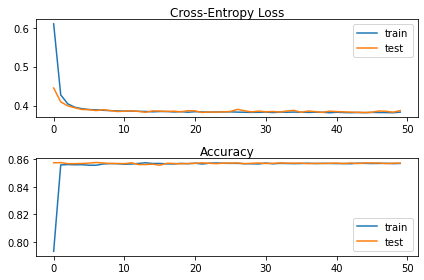

In [41]:
# fit model
history = model.fit(df_new_train, y_train, 
                    validation_data=(df_new_val, y_val), 
                    epochs=50, verbose=1, 
                    batch_size=32)

# evaluate the model
logger.info("Infering")
train_loss, train_acc = model.evaluate(df_new_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(df_new_val, y_val, verbose=0)
logger.info('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.tight_layout()
plt.show()

run.summary["Train Acc"] = train_acc
run.summary["Train Loss"] = train_loss
run.summary["Test Acc"] = test_acc
run.summary["Test Loss"] = test_loss

## 1.8 Export the best model

In [42]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "keras_model.h5"
artifact_pipe = "pipe_export.pkl"

In [43]:
logger.info("Dumping the artifacts to disk")
# Save the model
model.save(artifact_model) 

# Save the pipeline object with joblib
joblib.dump(full_pipeline_preprocessing, artifact_pipe)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

24-07-2022 16:40:12 Dumping the artifacts to disk


['target_encoder']

In [44]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A Neural Network model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

24-07-2022 16:40:12 Logging model artifact


In [45]:
# Pipeline artifact
artifact = wandb.Artifact(artifact_pipe,
                          type=artifact_type,
                          description="A pipeline with the Preprocessing Stage"
                          )

logger.info("Logging pipe artifact")
artifact.add_file(artifact_pipe)
run.log_artifact(artifact)

24-07-2022 16:40:12 Logging pipe artifact


In [46]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

24-07-2022 16:40:13 Logging target enconder artifact


In [47]:
run.finish()

Test Acc,0.85731
Test Loss,0.38696
Train Acc,0.85703
Train Loss,0.38217
